# User Engagement Analysis 
###### Under this task the user's engagement are tracked using the following metrics
* session frequency
* duration of the session
* the sessions total traffic(Download and Upload)

In [73]:
# import required packages and modules
import os
import sys
sys.path.insert(0,'../scripts/') 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#
import pickle
#
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly. graph_objects as go
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist

In [6]:
# importing scripts files
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from data_outliers import *
import plots

In [7]:
#sets the maximum number of columns to display when printing a DataFrame to be unlimited 
pd.set_option('display.max_columns', None)
#sets the maximum width of each column in characters to be unlimited (None)
pd.set_option('display.max_colwidth', None)
#controls whether to allow the DataFrame to stretch across multiple lines when printed
pd.set_option("expand_frame_repr", False)
#sets the floating-point formatting for displaying decimal numbers in the DataFrame to two decimal places ({:.2f}). 
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
# loading cleaned dataset

cleaned_data = pd.read_csv('../data/cleaned_dataset.csv')
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149001 entries, 0 to 149000
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      149001 non-null  int64  
 1   Unnamed:_0                      149001 non-null  int64  
 2   Bearer_Id                       149001 non-null  float64
 3   Start                           149001 non-null  object 
 4   Start_ms                        149001 non-null  float64
 5   End                             149001 non-null  object 
 6   End_ms                          149001 non-null  float64
 7   Dur._(ms)                       149001 non-null  float64
 8   IMSI                            149001 non-null  float64
 9   MSISDN_Number                   149001 non-null  float64
 10  IMEI                            149001 non-null  float64
 11  Last_Location_Name              149001 non-null  object 
 12  Avg_RTT_DL_(ms) 

### Task 3.1 Python script for the following task: 
  *  Aggregate the above metrics per customer id(MSISDN) and report the top customers per engagement metric
  * Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement
  * Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings
  *  Aggregate user total traffic per application and derive the top 10 most engaged users per application
  * Top 3 most used Applications
  * Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics.
      * What is the optimized value of k(use elbow method for this)?
      * Interpret your findings.

In [10]:
user_engagement_df = cleaned_data[['MSISDN_Number', 'Bearer_Id', 'Dur._(ms)', 'Total_Data_(Bytes)']].copy().rename(columns={
    'Bearer_Id': 'Session_Frequency', 
    'MSISDN_Number':'Customer_Id', 
    'Dur._(ms)': 'Duration', 
    'Total_Data_(Bytes)': 'Total_Data_Volume'})

In [11]:
#Aggregating Session_Frequency,Duration and Total_Data_Volume per Customer_Id and Displaying top 10 
user_engagement = user_engagement_df.groupby('Customer_Id').agg({'Session_Frequency': 'count', 'Duration': 'sum', 'Total_Data_Volume': 'sum'})
user_engagement.head(10)

,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,
33601001722.00,1,116720.00,878690574.00
33601001754.00,1,181230.00,156859643.00
33601002511.00,1,134969.00,595966483.00
33601007832.00,1,49878.00,422320698.00
33601008617.00,2,37104.00,1457410944.00
33601010682.00,2,253983.00,615217221.00
33601011634.00,2,128360.00,654723066.00
33601011959.00,1,86399.00,332660357.00
33601014694.00,2,242249.00,990132189.00


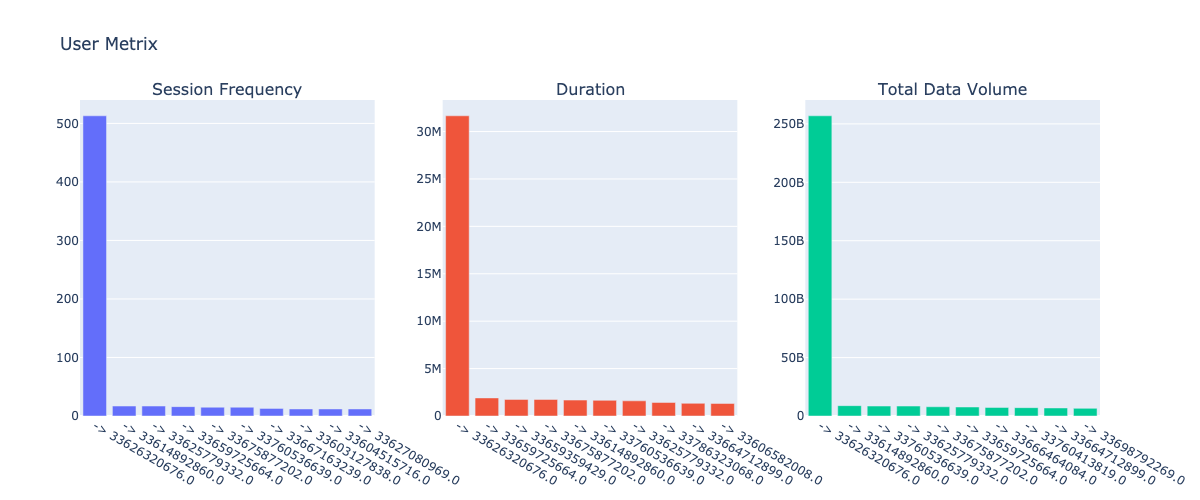

In [13]:
#Displaying top 10  customer engagement
sessions = user_engagement.nlargest(10, "Session_Frequency")['Session_Frequency']
duration = user_engagement.nlargest(10, "Duration")['Duration']
total_data_volume = user_engagement.nlargest(10, "Total_Data_Volume")['Total_Data_Volume']

plots.mult_hist([sessions, duration, total_data_volume], 1,
          3, "User Metrix", ['Session Frequency', 'Duration', 'Total Data Volume'])

<Axes: >

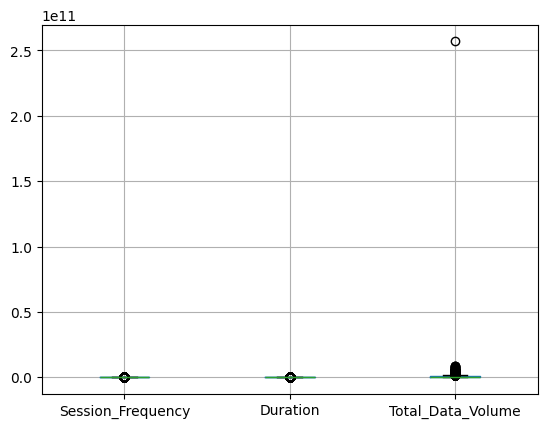

In [12]:
# Check for outliers 

user_engagement.boxplot()

In [37]:
#Normalize the Engagement Metrics
scaler = StandardScaler()#Create a scaler object # Initialize StandardScaler
scaled_array = scaler.fit_transform(user_engagement)#Fit and transform the data
scaled_df = pd.DataFrame(scaled_array, columns=user_engagement.columns)
print(scaled_df.head(5))

   Session_Frequency  Duration  Total_Data_Volume
0              -0.23     -0.09               0.20
1              -0.23      0.38              -0.58
2              -0.23      0.04              -0.11
3              -0.23     -0.57              -0.29
4               0.34     -0.66               0.82


In [36]:
data_normalized = normalize(scaled_df)
normalized_df = pd.DataFrame(data_normalized, columns=scaled_df.columns)
print(normalized_df.head(5))

   Session_Frequency  Duration  Total_Data_Volume
0              -0.72     -0.27               0.64
1              -0.31      0.52              -0.80
2              -0.89      0.18              -0.42
3              -0.34     -0.84              -0.43
4               0.31     -0.59               0.74


In [38]:
# K=3 to classify customers 
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([1, 2, 2, ..., 1, 1, 1], dtype=int32)

In [39]:
user_engagement.insert(0, 'Cluster', kmeans.labels_)
user_engagement.head(5)

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,1,1,116720.00,878690574.00
33601001754.00,2,1,181230.00,156859643.00
33601002511.00,2,1,134969.00,595966483.00
33601007832.00,1,1,49878.00,422320698.00
33601008617.00,0,2,37104.00,1457410944.00


In [41]:
user_engagement['Cluster'].value_counts()

1    58190
0    26132
2    22149
Name: Cluster, dtype: int64

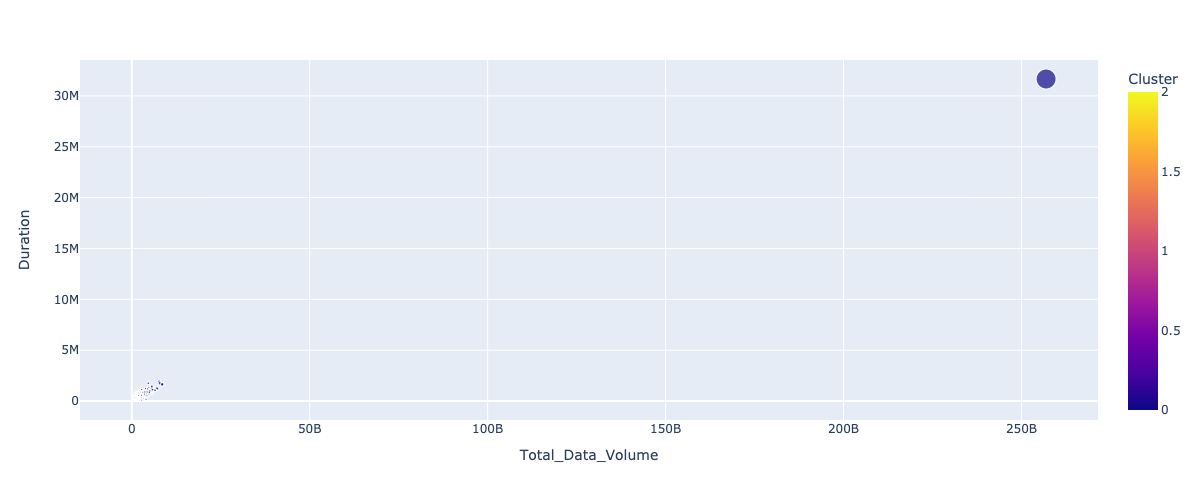

In [42]:
from IPython.display import Image
fig = px.scatter(user_engagement, x='Total_Data_Volume', y="Duration", color='Cluster', size='Session_Frequency')
Image(pio.to_image(fig, format='png', width=1200))

In [47]:
#Compute the minimum, maximum, average & total non-normalized metrics for each cluster. 
#Interpret your results visually with accompanying text explaining your findings
cluster1 = user_engagement[user_engagement["Cluster"]==0]
print("Cluster 1 Description (Non-Normalized):")
cluster1.describe()

Cluster 1 Description (Non-Normalized):


,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,26132.00,26132.00,26132.00,26132.00
mean,0.00,2.51,238647.08,1277221036.77
std,0.00,3.30,234582.31,1689475514.40
min,0.00,1.00,23292.00,284218230.00
25%,0.00,2.00,166073.75,887725856.75
50%,0.00,2.00,206452.50,1165149337.00
75%,0.00,3.00,296256.75,1513512741.75
max,0.00,513.00,31659828.00,256924175724.00


In [60]:
cluster1 = user_engagement[user_engagement["Cluster"]==1]
print("Cluster 2 Description (Non-Normalized):")
cluster1.describe()

Cluster 2 Description (Non-Normalized):


,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,58190.00,58190.00,58190.00,58190.00
mean,1.00,1.05,67127.21,512228239.69
std,0.00,0.21,30397.67,249198122.11
min,1.00,1.00,7142.00,33249009.00
25%,1.00,1.00,36817.00,301327167.25
50%,1.00,1.00,85137.50,516166665.00
75%,1.00,1.00,86400.00,722193280.75
max,1.00,2.00,125590.00,1369039253.00


In [61]:
cluster1 = user_engagement[user_engagement["Cluster"]==2]
print("Cluster 3 Description (Non-Normalized):")
cluster1.describe()

Cluster 3 Description (Non-Normalized):


,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,22149.00,22149.00,22149.00,22149.00
mean,2.00,1.01,160878.43,482769512.01
std,0.00,0.11,29878.37,244592486.62
min,2.00,1.00,111797.00,33575840.00
25%,2.00,1.00,137670.00,269215121.00
50%,2.00,1.00,156483.00,475693695.00
75%,2.00,1.00,175248.00,693918115.00
max,2.00,2.00,421295.00,950760661.00


In [55]:
#Aggregate user total traffic per application and derive the top 10 most engaged users per application
app_df = cleaned_data.groupby('MSISDN_Number').agg({
    'Gaming_(Bytes)': 'sum', 
    'Youtube_(Bytes)': 'sum', 
    'Netflix_(Bytes)': 'sum',\
    'Google_(Bytes)': 'sum', 
    'Email_(Bytes)': 'sum', 
    'Social_Media_(Bytes)': 'sum', 
    'Other_(Bytes)': 'sum'})
app_df.head()

,Gaming_(Bytes),Youtube_(Bytes),Netflix_(Bytes),Google_(Bytes),Email_(Bytes),Social_Media_(Bytes),Other_(Bytes)
MSISDN_Number,,,,,,,
33601001722.00,812458661.00,21624548.00,27180981.00,4389005.00,1331362.00,2232135.00,386570872.00
33601001754.00,119750078.00,12432223.00,11221763.00,5334863.00,3307781.00,2660565.00,281710071.00
33601002511.00,538827713.00,21333570.00,19353900.00,3443126.00,3205380.00,3195623.00,501693672.00
33601007832.00,391126127.00,6977321.00,1942092.00,9678493.00,2284670.00,280294.00,35279702.00
33601008617.00,1314797820.00,41533002.00,49201724.00,18499616.00,3305469.00,2912542.00,804804484.00


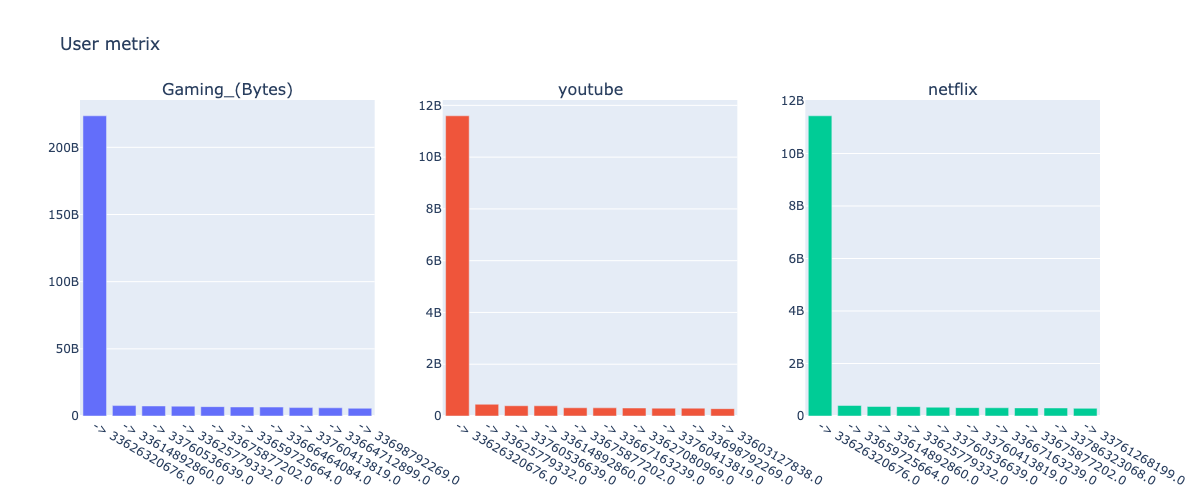

In [56]:
gaming = app_df.nlargest(10, "Gaming_(Bytes)")['Gaming_(Bytes)']
youtube = app_df.nlargest(10, "Youtube_(Bytes)")['Youtube_(Bytes)']
netflix = app_df.nlargest(10, "Netflix_(Bytes)")['Netflix_(Bytes)']
google = app_df.nlargest(10, "Google_(Bytes)")['Google_(Bytes)']
email = app_df.nlargest(10, "Email_(Bytes)")['Email_(Bytes)']
social_media = app_df.nlargest(10, "Social_Media_(Bytes)")['Social_Media_(Bytes)']
other = app_df.nlargest(10, "Other_(Bytes)")['Other_(Bytes)']


plots.mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["Gaming_(Bytes)", "youtube", "netflix"])

#plots.mult_hist([google, email, social_media, other], 1,
        #  4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

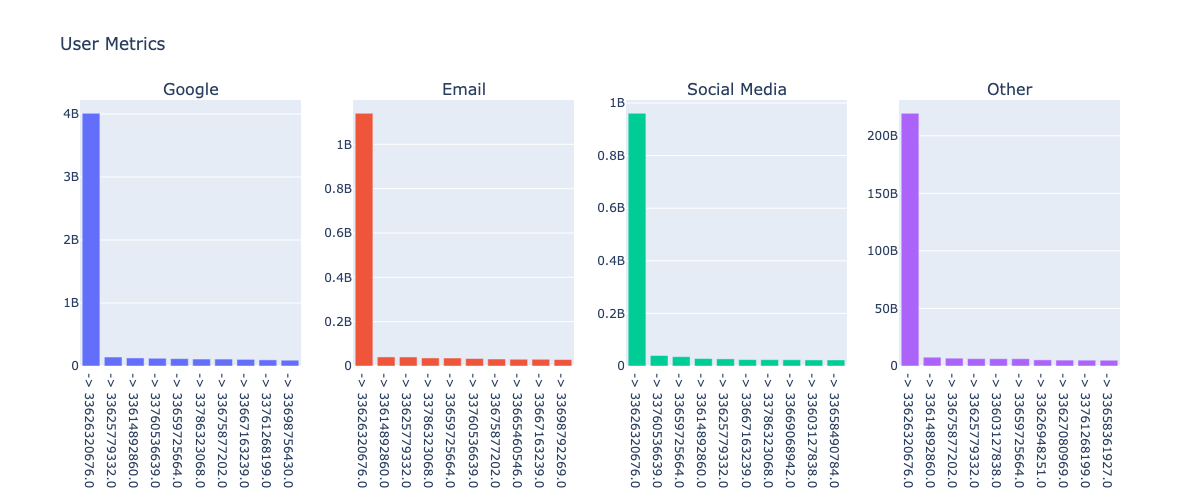

In [57]:
plots.mult_hist([google, email, social_media, other], 1,
         4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

###### Top 3 most used Applications

In [58]:
top_3 = app_df.sum()
top_3

Gaming_(Bytes)         64126718859639.00
Youtube_(Bytes)         3373759732066.00
Netflix_(Bytes)         3371671002856.00
Google_(Bytes)          1163403259609.00
Email_(Bytes)            336600461891.00
Social_Media_(Bytes)     272396244306.00
Other_(Bytes)          63982112708682.00
dtype: float64

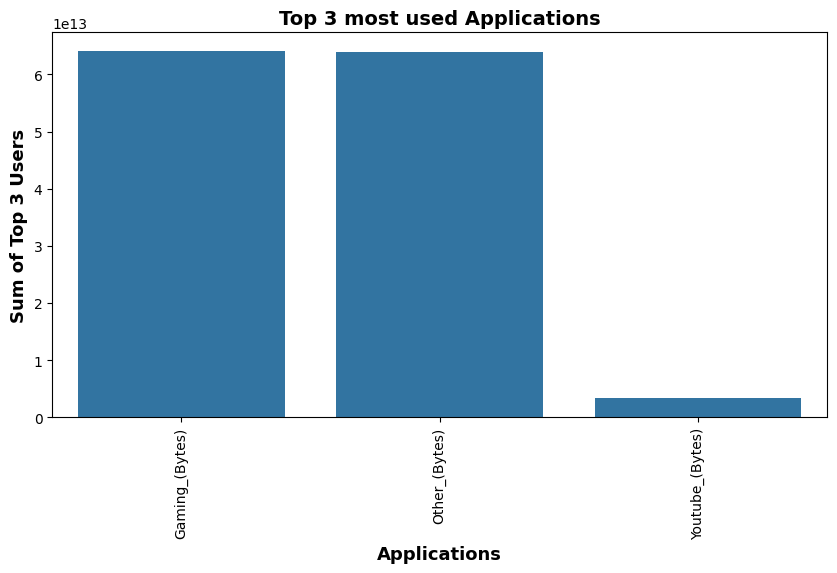

In [62]:
plots.plot_bar(top_3.nlargest(3), "Top 3 most used Applications", "Applications", "Sum of Top 3 Users")

In [63]:
#Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. 
#Inertia is the sum of squared distances of samples to their closest cluster centre
def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)


  return (distortions, inertias)

In [68]:
distortions, inertias = choose_kmeans(data_normalized, 15)
print("Distortions:", distortions)
print("Inertias:", inertias)

Distortions: [0.9318024674879256, 0.6255744943137701, 0.510192834468061, 0.41650259805824585, 0.37463748609351966, 0.3360093493949849, 0.3149554537226126, 0.28506812627625117, 0.27480004878458564, 0.26170429319168764, 0.2522031515801663, 0.24676017279683396, 0.2313888814873401, 0.2188139512679648]
Inertias: [97088.79403857159, 49729.72066174613, 33728.218924552915, 24539.41146064191, 19221.76685606873, 15229.53347216943, 13274.12714883775, 11403.345483397348, 10257.930873609497, 9092.9708602738, 8409.184978752106, 8043.1920287732955, 7242.0949064370525, 6710.987634086521]


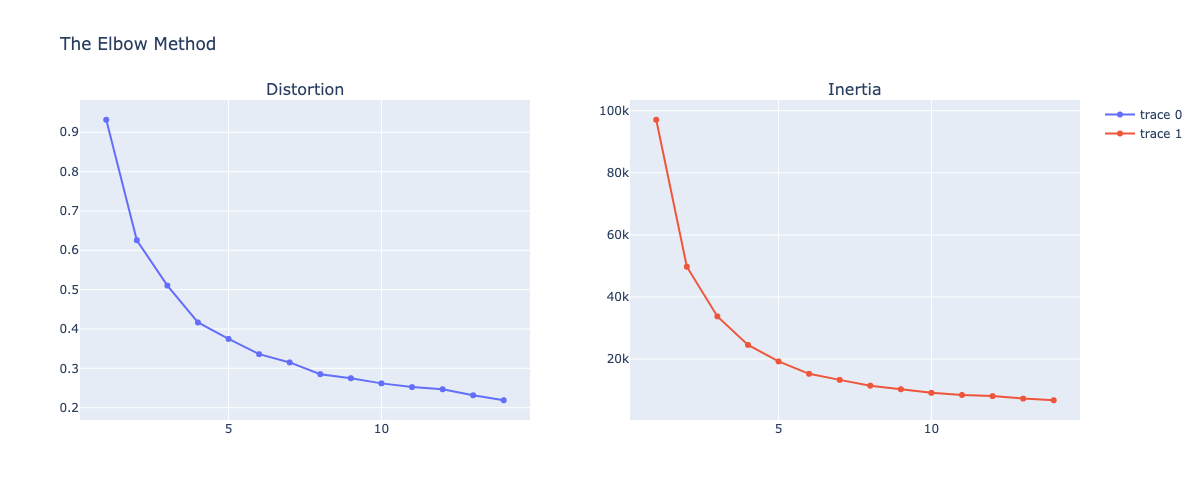

In [67]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

Based on the above plots we can see that 4 cluster value is optimal,b/c there is no significant decrease in distortion and inertia


In [70]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
user_engagement["Cluster"]= kmeans.labels_
user_engagement

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,3,1,116720.00,878690574.00
33601001754.00,2,1,181230.00,156859643.00
33601002511.00,2,1,134969.00,595966483.00
33601007832.00,1,1,49878.00,422320698.00
33601008617.00,3,2,37104.00,1457410944.00
...,...,...,...,...
33789996170.00,3,1,8810.00,714641641.00
33789997247.00,2,1,140988.00,480307335.00
3197020876596.00,1,1,86399.00,232123971.00


In [78]:
# save the models 
with open("../models/user_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)


In [81]:
#save th
user_engagement.to_csv('../data/user_engagement.csv')